# Late Fusion Model for Outcome Classification

This notebook implements late fusion combining:
- **Physiological data** (pupil metrics)
- **Behavioral data** (reaction time, decision time, etc.)
- **Gaze data** (gaze position, movements, fixations)

Goals:
1. Train separate models for each modality
2. Implement late fusion (stacking/weight averaging)
3. Extract weights to estimate modality influence on predictions

In [1]:
import json
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, LeaveOneGroupOut
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)
sns.set_style('whitegrid')

## 1. Load Preprocessed Physiology and Behavior Data

In [2]:
import re

preprocessing_dir = Path('../data/results/preprocessing')
preprocessing_files = sorted(preprocessing_dir.glob('preprocessing_*.json'))
raw_dir = Path('../data/json')
baseline_method = 't3_stable_pre_decision'  # Same as outcome_classification

print(f"Found {len(preprocessing_files)} preprocessing files")
print(f"Baseline correction method: {baseline_method}")

Found 10 preprocessing files
Baseline correction method: t3_stable_pre_decision


In [3]:
# =============================================================================
# EXTRACT FEATURES FOR ALL SUBJECTS (Same as outcome_classification.ipynb)
# =============================================================================
all_physiology_features = []
all_behavior_features = []
all_outcomes = []
all_subject_ids = []
all_trial_ids = []

for preprocessed_file in preprocessing_files:
    
    # Load preprocessed data
    with open(preprocessed_file, 'r') as f:
        preprocessed = json.load(f)
    
    subject_id = preprocessed['subject_id']
    print(f"\nProcessing subject: {subject_id}")
    
    # Find corresponding raw data file
    matches = list(raw_dir.glob(f"*{subject_id.split('_')[-1]}.json"))
    pattern = subject_id.replace("_", ".*")
    match = next((f for f in matches if re.search(pattern, f.name)), None)
    if not match:
        print("No matching file found.")
        continue
    
    with open(match, 'r') as f:
        raw_data = json.load(f)
    
    subject_trial_count = 0
    
    for trial_id, trial_data in preprocessed['trial_data'].items():

        # Get the baseline-corrected pupil data for chosen method
        method_data = trial_data['methods'][baseline_method]
        
        if method_data['success'] != True:
            continue
        
        # Get raw trial data for behavioral features
        raw_trial = raw_data['trials'][int(trial_id)-1]
        
        # Skip trials that weren't submitted
        if not raw_trial['gamble details']['submitted']:
            continue
        
        # =============================================================================
        # PHYSIOLOGY FEATURES (PRE + POST SUBMIT)
        # =============================================================================

        # Split data into pre-submit and post-submit periods
        time_aligned = np.array(trial_data['time_relative_to_submit'])
        pupil_avg = np.array(method_data['pupil_avg_baselined'])
        pupil_L = np.array(method_data['pupil_L_baselined'])
        pupil_R = np.array(method_data['pupil_R_baselined'])

        # Remove NaN values
        valid_mask = ~np.isnan(pupil_avg)
        pupil_avg_clean = pupil_avg[valid_mask]
        pupil_L_clean = pupil_L[valid_mask]
        pupil_R_clean = pupil_R[valid_mask]
        time_clean = time_aligned[valid_mask]

        if len(pupil_avg_clean) < 20:
            continue

        # ============= PRE-SUBMIT DATA (for prediction) =============
        pre_submit_mask = time_clean <= 0
        pupil_pre = pupil_avg_clean[pre_submit_mask]
        pupil_L_pre = pupil_L_clean[pre_submit_mask]
        pupil_R_pre = pupil_R_clean[pre_submit_mask]
        time_pre = time_clean[pre_submit_mask]

        # Check minimum samples for pre-submit
        if len(pupil_pre) < 10:
            continue

        # Calculate derivatives for pre-submit
        pupil_velocity_pre = np.diff(pupil_pre) if len(pupil_pre) > 1 else np.array([0])
        pupil_acceleration_pre = np.diff(pupil_velocity_pre) if len(pupil_velocity_pre) > 1 else np.array([0])
        dilation_mask_pre = pupil_velocity_pre > 0 if len(pupil_velocity_pre) > 0 else np.array([False])

        # ============= POST-SUBMIT DATA (for outcome response) =============
        post_submit_mask = (time_clean > 0) & (time_clean <= 2.0)
        pupil_post = pupil_avg_clean[post_submit_mask]
        pupil_L_post = pupil_L_clean[post_submit_mask]
        pupil_R_post = pupil_R_clean[post_submit_mask]
        time_post = time_clean[post_submit_mask]

        # Calculate derivatives for post-submit (if enough samples)
        if len(pupil_post) > 1:
            pupil_velocity_post = np.diff(pupil_post)
            pupil_acceleration_post = np.diff(pupil_velocity_post) if len(pupil_velocity_post) > 1 else np.array([0])
            dilation_mask_post = pupil_velocity_post > 0 if len(pupil_velocity_post) > 0 else np.array([False])
        else:
            pupil_velocity_post = np.array([0])
            pupil_acceleration_post = np.array([0])
            dilation_mask_post = np.array([False])

        # =============================================================================
        # EXTRACT FEATURES FOR BOTH PERIODS
        # =============================================================================

        physiology_features = {
            # ==================== PRE-SUBMIT FEATURES ====================
            # Central tendency
            'pupil_mean_pre': np.mean(pupil_pre),
            'pupil_std_pre': np.std(pupil_pre),
            
            # Temporal dynamics
            'pupil_slope_pre': np.polyfit(time_pre, pupil_pre, 1)[0] if len(time_pre) > 1 else 0,
            'time_to_peak_pre': time_pre[np.argmax(pupil_pre)] - time_pre[0] if len(time_pre) > 0 else 0,
            
            # Change from start to end
            'pupil_change_pre': (np.mean(pupil_pre[-min(10, len(pupil_pre)):]) - 
                                np.mean(pupil_pre[:min(10, len(pupil_pre))])) if len(pupil_pre) >= 10 else 0,
            
            # Variability
            'pupil_cv_pre': np.std(pupil_pre) / np.abs(np.mean(pupil_pre)) if (len(pupil_pre) > 0 and np.mean(pupil_pre) != 0) else 0,
            
            # Velocity metrics
            'pupil_velocity_mean_pre': np.mean(np.abs(pupil_velocity_pre)) if len(pupil_velocity_pre) > 0 else 0,
            'pupil_max_dilation_rate_pre': np.max(pupil_velocity_pre) if len(pupil_velocity_pre) > 0 else 0,
            'pupil_max_constriction_rate_pre': np.abs(np.min(pupil_velocity_pre)) if len(pupil_velocity_pre) > 0 else 0,
            
            # Acceleration
            'pupil_acceleration_std_pre': np.std(pupil_acceleration_pre) if len(pupil_acceleration_pre) > 1 else 0,
            
            # Temporal patterns
            'pct_time_dilating_pre': np.mean(dilation_mask_pre) if len(dilation_mask_pre) > 0 else 0,
            'num_dilation_peaks_pre': np.sum(np.diff(np.sign(pupil_velocity_pre)) > 0) if len(pupil_velocity_pre) > 1 else 0,
            
            # Eye asymmetry
            'eye_asymmetry_pre': np.nanmean(np.abs(pupil_L_pre - pupil_R_pre)) if len(pupil_L_pre) > 0 else 0,
            'eye_asymmetry_std_pre': np.nanstd(pupil_L_pre - pupil_R_pre) if len(pupil_L_pre) > 1 else 0,
            
            # ==================== POST-SUBMIT FEATURES ====================
            # Central tendency
            'pupil_mean_post': np.mean(pupil_post) if len(pupil_post) > 0 else 0,
            'pupil_std_post': np.std(pupil_post) if len(pupil_post) > 1 else 0,
            
            # Temporal dynamics
            'pupil_slope_post': np.polyfit(time_post, pupil_post, 1)[0] if len(time_post) > 1 else 0,
            'time_to_peak_post': time_post[np.argmax(pupil_post)] - time_post[0] if len(time_post) > 0 else 0,
            
            # Variability
            'pupil_cv_post': np.std(pupil_post) / np.abs(np.mean(pupil_post)) if (len(pupil_post) > 0 and np.mean(pupil_post) != 0) else 0,
            
            # Velocity metrics
            'pupil_velocity_mean_post': np.mean(np.abs(pupil_velocity_post)) if len(pupil_velocity_post) > 0 else 0,
            'pupil_max_dilation_rate_post': np.max(pupil_velocity_post) if len(pupil_velocity_post) > 0 else 0,
            'pupil_max_constriction_rate_post': np.abs(np.min(pupil_velocity_post)) if len(pupil_velocity_post) > 0 else 0,
            
            # Temporal patterns
            'pct_time_dilating_post': np.mean(dilation_mask_post) if len(dilation_mask_post) > 0 else 0,
            'num_dilation_peaks_post': np.sum(np.diff(np.sign(pupil_velocity_post)) > 0) if len(pupil_velocity_post) > 1 else 0,
            
            # Eye asymmetry
            'eye_asymmetry_post': np.nanmean(np.abs(pupil_L_post - pupil_R_post)) if len(pupil_L_post) > 0 else 0,
            'eye_asymmetry_std_post': np.nanstd(pupil_L_post - pupil_R_post) if len(pupil_L_post) > 1 else 0,
            
            # ==================== TRANSITION FEATURES ====================
            # Compare pre vs post
            'pupil_mean_change_pre_to_post': (np.mean(pupil_post) - np.mean(pupil_pre)) if len(pupil_post) > 0 and len(pupil_pre) > 0 else 0,
            'pupil_slope_change_pre_to_post': ((np.polyfit(time_post, pupil_post, 1)[0] if len(time_post) > 1 else 0) - 
                                            (np.polyfit(time_pre, pupil_pre, 1)[0] if len(time_pre) > 1 else 0)),
            
            # ==================== BASELINE ====================
            'baseline_L': method_data['baseline_L'],
            'baseline_R': method_data['baseline_R'],
            'baseline_avg': (method_data['baseline_L'] + method_data['baseline_R']) / 2,
        }
        
        # =============================================================================
        # BEHAVIOR FEATURES (from raw trial data)
        # =============================================================================
        gamble_params = raw_trial['gamble details']['gamble parameters']
        lct = raw_trial['lct']
        
        # Extract timing information
        show_screen_time = None
        submit_time = None
        click_time = None
        
        for event in lct:
            if 'show screen' in event['event']:
                show_screen_time = event['time']
            elif 'gamble clicked' in event['event']:
                click_time = event['time']
            elif 'submit' in event['event']:
                submit_time = event['time']
        
        if show_screen_time is None or submit_time is None:
            continue
        
        # Calculate timing metrics (convert to seconds)
        reaction_time = (click_time - show_screen_time) / 1000 if click_time else np.nan
        decision_time = (submit_time - show_screen_time) / 1000

        # Calculate expected values
        invest_ev = (gamble_params['invest amount 1'] * gamble_params['invest probability 1'] + 
                    gamble_params['invest amount 2'] * gamble_params['invest probability 2'])
        keep_ev = gamble_params['keep amount']
        ev_difference = invest_ev - keep_ev

        # Calculate variance
        invest_variance = ((gamble_params['invest amount 1'] - invest_ev)**2 * gamble_params['invest probability 1'] +
                        (gamble_params['invest amount 2'] - invest_ev)**2 * gamble_params['invest probability 2'])
        
        # Choice information
        final_choice = raw_trial['gamble details']['choices'][-1]['choice'] if len(raw_trial['gamble details']['choices']) > 0 else None
        chose_invest = 1 if final_choice == 'INVEST' else 0
        
        behavior_features = {
            # TIMING - Independent information
            'reaction_time': reaction_time if not np.isnan(reaction_time) else decision_time,
            'decision_time': decision_time,
            
            # GAMBLE PARAMETERS 
            'ev_difference': ev_difference,
            
            # RISK - Independent from EV
            'invest_variance': invest_variance,
            
            # AMBIGUITY - Independent
            'ambiguity': gamble_params['ambiguity'],
            
            # CONDITION - Independent  
            'condition_social': 1 if gamble_params['condition'] == 'social' else 0,
            
            # NORMALIZED RISK METRIC - Independent combination
            'risk_premium': ev_difference / np.sqrt(invest_variance) if invest_variance > 0 else 0,
        }
                
        # =============================================================================
        # OUTCOME VARIABLE
        # =============================================================================
        outcome = chose_invest  # Predicting INVEST (1) vs KEEP (0)
        
        # Store everything
        all_physiology_features.append(physiology_features)
        all_behavior_features.append(behavior_features)
        all_outcomes.append(outcome)
        all_subject_ids.append(subject_id)
        all_trial_ids.append(f"{trial_id}_{subject_id}")
        
        subject_trial_count += 1
    
    print(f"  Extracted {subject_trial_count} valid trials")

# =============================================================================
# CREATE DATAFRAMES
# =============================================================================
physio_df = pd.DataFrame(all_physiology_features)
physio_df.insert(0, 'subject_id', all_subject_ids)
physio_df.insert(1, 'trial_id', all_trial_ids)
physio_df['outcome'] = all_outcomes

behavior_df = pd.DataFrame(all_behavior_features)
behavior_df.insert(0, 'subject_id', all_subject_ids)
behavior_df.insert(1, 'trial_id', all_trial_ids)
behavior_df['outcome'] = all_outcomes

print(f"\n{'='*80}")
print(f"Physiology: {len(physio_df)} trials, {len([c for c in physio_df.columns if c not in ['subject_id', 'trial_id', 'outcome']])} features")
print(f"Behavior: {len(behavior_df)} trials, {len([c for c in behavior_df.columns if c not in ['subject_id', 'trial_id', 'outcome']])} features")


Processing subject: 0927_0930_U9TEJGM
  Extracted 99 valid trials

Processing subject: 0928_1600_539136F
  Extracted 110 valid trials

Processing subject: 0928_1600_9M4VCHG
  Extracted 117 valid trials

Processing subject: 0928_1600_U9TEJGM
  Extracted 93 valid trials

Processing subject: 0930_1700_539136F
  Extracted 95 valid trials

Processing subject: 0930_1700_9M4VCHG
  Extracted 112 valid trials

Processing subject: 0930_1700_U9TEJGM
  Extracted 123 valid trials

Processing subject: 1005_1600_539136F
  Extracted 121 valid trials

Processing subject: 1005_1600_9M4VCHG
  Extracted 123 valid trials

Processing subject: 1005_1600_U9TEJGM
  Extracted 51 valid trials

Physiology: 1044 trials, 31 features
Behavior: 1044 trials, 7 features


## 2. Load and Preprocess Gaze Data

In [4]:
raw_json_dir = Path('../data/json')
raw_json_files = sorted(raw_json_dir.glob('*.json'))
print(f"Found {len(raw_json_files)} raw JSON files")

Found 10 raw JSON files


In [5]:
def extract_gaze_features_from_trial(eye_data):
    """Extract gaze features from raw eye tracking data."""
    if not eye_data or len(eye_data) == 0:
        return None
    
    timestamps = np.array([s['time'] for s in eye_data])
    
    # Gaze 3D coordinates
    gaze_x_L = np.array([s.get('gazeL_X', np.nan) for s in eye_data])
    gaze_y_L = np.array([s.get('gazeL_Y', np.nan) for s in eye_data])
    gaze_x_R = np.array([s.get('gazeR_X', np.nan) for s in eye_data])
    gaze_y_R = np.array([s.get('gazeR_Y', np.nan) for s in eye_data])
    
    gaze_x = np.nanmean([gaze_x_L, gaze_x_R], axis=0)
    gaze_y = np.nanmean([gaze_y_L, gaze_y_R], axis=0)
    
    # Screen position (normalized)
    screen_x_L = np.array([s.get('pupilLSensorPosL_X', np.nan) for s in eye_data])
    screen_y_L = np.array([s.get('pupilLSensorPosL_Y', np.nan) for s in eye_data])
    screen_x_R = np.array([s.get('pupilLSensorPosR_X', np.nan) for s in eye_data])
    screen_y_R = np.array([s.get('pupilLSensorPosR_Y', np.nan) for s in eye_data])
    
    screen_x = np.nanmean([screen_x_L, screen_x_R], axis=0)
    screen_y = np.nanmean([screen_y_L, screen_y_R], axis=0)
    
    # Validity
    valid_L = np.array([s.get('validL', 0) for s in eye_data])
    valid_R = np.array([s.get('validR', 0) for s in eye_data])
    
    features = {}
    features['gaze_valid_pct'] = np.mean((valid_L > 0) & (valid_R > 0))
    
    # Filter valid samples
    valid_mask = (valid_L > 0) & (valid_R > 0)
    if valid_mask.sum() < 5:
        return None
    
    gaze_x_valid = gaze_x[valid_mask]
    gaze_y_valid = gaze_y[valid_mask]
    screen_x_valid = screen_x[valid_mask]
    screen_y_valid = screen_y[valid_mask]
    timestamps_valid = timestamps[valid_mask]
    
    # Statistics
    features['gaze_x_mean'] = np.nanmean(gaze_x_valid)
    features['gaze_x_std'] = np.nanstd(gaze_x_valid)
    features['gaze_y_mean'] = np.nanmean(gaze_y_valid)
    features['gaze_y_std'] = np.nanstd(gaze_y_valid)
    features['screen_x_mean'] = np.nanmean(screen_x_valid)
    features['screen_x_std'] = np.nanstd(screen_x_valid)
    features['screen_y_mean'] = np.nanmean(screen_y_valid)
    features['screen_y_std'] = np.nanstd(screen_y_valid)
    
    # Movement metrics
    dt = np.diff(timestamps_valid)
    dt[dt == 0] = 1e-6
    dx = np.diff(screen_x_valid)
    dy = np.diff(screen_y_valid)
    
    velocity = np.sqrt(dx**2 + dy**2) / dt
    features['gaze_velocity_mean'] = np.nanmean(velocity)
    features['gaze_velocity_std'] = np.nanstd(velocity)
    features['gaze_velocity_max'] = np.nanmax(velocity)
    
    acceleration = np.diff(velocity) / dt[:-1]
    features['gaze_acceleration_mean'] = np.nanmean(np.abs(acceleration))
    features['gaze_acceleration_std'] = np.nanstd(acceleration)
    
    # Fixations and saccades
    fixation_mask = velocity < 30
    saccade_mask = velocity > 100
    features['fixation_ratio'] = np.mean(fixation_mask)
    features['saccade_ratio'] = np.mean(saccade_mask)
    features['saccade_count'] = np.sum(np.diff(saccade_mask.astype(int)) == 1)
    
    # Dispersion
    features['gaze_dispersion_x'] = np.nanmax(screen_x_valid) - np.nanmin(screen_x_valid)
    features['gaze_dispersion_y'] = np.nanmax(screen_y_valid) - np.nanmin(screen_y_valid)
    
    # Path length
    features['gaze_path_length'] = np.sum(np.sqrt(dx**2 + dy**2))
    
    return features

In [15]:
def map_subject_filename(json_filename):
    """Map raw JSON filename to subject ID."""
    import re
    match = re.search(r'(\d{4})_(\d{4})_LCT_DESKTOP-([A-Z0-9]+)', json_filename)
    if match:
        date1, date2, desktop_id = match.groups()
        return f"{date1}_{date2}_{desktop_id}"
    return None

def extract_gaze_data(raw_json_files):
    """Extract gaze features from all raw JSON files."""
    all_gaze_data = []
    
    for file_path in raw_json_files:
        with open(file_path, 'r') as f:
            data = json.load(f)
        
        subject_id = map_subject_filename(file_path.name)
        if not subject_id:
            continue
        
        trials = data.get('trials', [])
        
        for trial_idx, trial in enumerate(trials):
            eye_data = trial.get('eye', [])
            if not eye_data:
                continue
            
            gamble_details = trial.get('gamble details', {})
            trial_id = str(gamble_details.get('trial', trial_idx))
            
            gaze_features = extract_gaze_features_from_trial(eye_data)
            if gaze_features is None:
                continue
            
            gaze_features['subject_id'] = subject_id
            gaze_features['trial_id'] = f"{trial_id}_{subject_id}"
            all_gaze_data.append(gaze_features)
    
    gaze_df = pd.DataFrame(all_gaze_data)
    print(f"Gaze: {len(gaze_df)} trials, {len([c for c in gaze_df.columns if c not in ['subject_id', 'trial_id']])} features")
    return gaze_df

gaze_df = extract_gaze_data(raw_json_files)

Gaze: 1383 trials, 20 features


## 3. Merge All Modalities

In [19]:
# Merge on subject_id and trial_id
merged_df = physio_df.merge(
        behavior_df.drop(columns=['outcome']),
        on=['subject_id', 'trial_id'],
        how='inner'
    )

# Then merge with gaze data
merged_df = merged_df.merge(
    gaze_df,
    on=['subject_id', 'trial_id'],
    how='inner'
)

print(f"Merged data: {len(merged_df)} trials")
print(f"Outcome distribution:\n{merged_df['outcome'].value_counts()}")

Merged data: 1044 trials
Outcome distribution:
outcome
1    688
0    356
Name: count, dtype: int64


## 4. Prepare Feature Sets

In [20]:
# Identify features for each modality
# Physiology features (33 features total)
physio_cols = [c for c in merged_df.columns 
               if any(t in c for t in ['pupil_', 'baseline_', 'eye_asymmetry'])]

# Behavior features (7 features total)
behavior_cols = ['reaction_time', 'decision_time', 'ev_difference', 
                 'invest_variance', 'ambiguity', 'condition_social', 'risk_premium']

# Gaze features
gaze_cols = [c for c in merged_df.columns 
             if c.startswith('gaze_') or c.startswith('screen_') or 
             c in ['fixation_ratio', 'saccade_ratio', 'saccade_count', 'gaze_valid_pct',
                   'gaze_dispersion_x', 'gaze_dispersion_y', 'gaze_path_length']]

print(f"Physiology: {len(physio_cols)} features")
print(f"Behavior: {len(behavior_cols)} features")
print(f"Gaze: {len(gaze_cols)} features")

# Extract and impute
X_physio = SimpleImputer(strategy='mean').fit_transform(merged_df[physio_cols])
X_behavior = SimpleImputer(strategy='mean').fit_transform(merged_df[behavior_cols])
X_gaze = SimpleImputer(strategy='mean').fit_transform(merged_df[gaze_cols])
y = merged_df['outcome'].values
subjects = merged_df['subject_id'].values

print(f"\nShapes: X_physio={X_physio.shape}, X_behavior={X_behavior.shape}, X_gaze={X_gaze.shape}")

Physiology: 25 features
Behavior: 7 features
Gaze: 20 features

Shapes: X_physio=(1044, 25), X_behavior=(1044, 7), X_gaze=(1044, 20)


## 5. Train Individual Modality Models

In [21]:
def train_evaluate_modality(X, y, subjects, modality_name):
    """Train and evaluate model with LOSO cross-validation."""
    print(f"\n{'='*50}\n{modality_name} Model\n{'='*50}")
    
    model = RandomForestClassifier(n_estimators=100, max_depth=5, min_samples_split=10,
                                   min_samples_leaf=5, random_state=42)
    logo = LeaveOneGroupOut()
    
    accs, f1s, preds_all, y_true_all = [], [], [], []
    
    for train_idx, test_idx in logo.split(X, y, subjects):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted')
        accs.append(acc)
        f1s.append(f1)
        preds_all.extend(y_pred)
        y_true_all.extend(y_test)
    
    print(f"Accuracy: {np.mean(accs):.3f} ± {np.std(accs):.3f}")
    print(f"F1-Score: {np.mean(f1s):.3f} ± {np.std(f1s):.3f}")
    
    return model, np.mean(accs), np.mean(f1s), preds_all, y_true_all

model_physio, acc_physio, f1_physio, pred_physio, y_true = train_evaluate_modality(
    X_physio, y, subjects, "Physiology"
)
model_behavior, acc_behavior, f1_behavior, pred_behavior, _ = train_evaluate_modality(
    X_behavior, y, subjects, "Behavior"
)
model_gaze, acc_gaze, f1_gaze, pred_gaze, _ = train_evaluate_modality(
    X_gaze, y, subjects, "Gaze"
)


Physiology Model
Accuracy: 0.669 ± 0.207
F1-Score: 0.628 ± 0.247

Behavior Model
Accuracy: 0.709 ± 0.170
F1-Score: 0.708 ± 0.191

Gaze Model
Accuracy: 0.672 ± 0.224
F1-Score: 0.584 ± 0.282



  Modality  Accuracy  F1-Score
Physiology  0.669438  0.628168
  Behavior  0.708978  0.708428
      Gaze  0.671909  0.583814


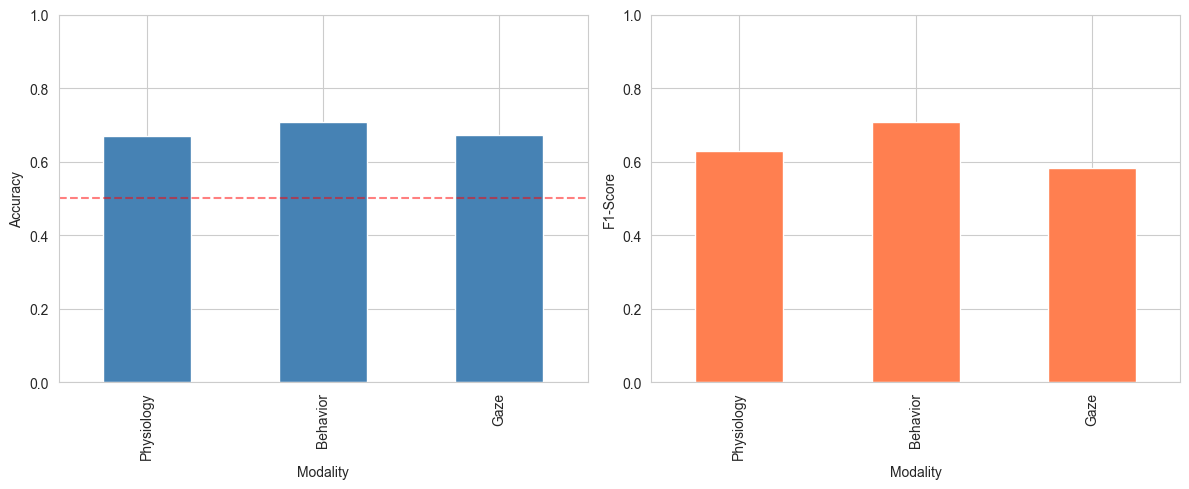

In [22]:
# Visualize individual performance
perf_df = pd.DataFrame({
    'Modality': ['Physiology', 'Behavior', 'Gaze'],
    'Accuracy': [acc_physio, acc_behavior, acc_gaze],
    'F1-Score': [f1_physio, f1_behavior, f1_gaze]
})

print("\n" + perf_df.to_string(index=False))

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
perf_df.plot(x='Modality', y='Accuracy', kind='bar', ax=ax[0], legend=False, color='steelblue')
ax[0].set_ylabel('Accuracy')
ax[0].set_ylim([0, 1])
ax[0].axhline(0.5, color='red', linestyle='--', alpha=0.5)
perf_df.plot(x='Modality', y='F1-Score', kind='bar', ax=ax[1], legend=False, color='coral')
ax[1].set_ylabel('F1-Score')
ax[1].set_ylim([0, 1])
plt.tight_layout()
plt.show()

## 6. Late Fusion Implementation

In [23]:
def late_fusion(X_modalities, y, subjects, modality_names, fusion_method='weighted'):
    """
    Late fusion by combining modality predictions.
    
    fusion_method:
    - 'average': Simple average of probabilities
    - 'weighted': Learn weights via logistic regression (meta-learner)
    - 'stacking': Random Forest meta-learner on probability predictions
    """
    print(f"\n{'='*50}\nLate Fusion: {fusion_method.upper()}\n{'='*50}")
    
    logo = LeaveOneGroupOut()
    base_models = [RandomForestClassifier(n_estimators=100, max_depth=5, min_samples_split=10,
                                          min_samples_leaf=5, random_state=42)
                   for _ in X_modalities]
    
    accs, f1s, all_weights = [], [], []
    preds_all, y_true_all = [], []
    
    for train_idx, test_idx in logo.split(X_modalities[0], y, subjects):
        # Train base models and get probabilities
        train_probs, test_probs = [], []
        
        for X, model in zip(X_modalities, base_models):
            X_train, X_test = X[train_idx], X[test_idx]
            y_train = y[train_idx]
            
            model.fit(X_train, y_train)
            train_probs.append(model.predict_proba(X_train)[:, 1])
            test_probs.append(model.predict_proba(X_test)[:, 1])
        
        train_probs = np.column_stack(train_probs)
        test_probs = np.column_stack(test_probs)
        y_train, y_test = y[train_idx], y[test_idx]
        
        # Fusion
        if fusion_method == 'average':
            y_pred = (np.mean(test_probs, axis=1) > 0.5).astype(int)
            weights = np.ones(len(X_modalities)) / len(X_modalities)
            
        elif fusion_method == 'weighted':
            meta = LogisticRegression(random_state=42, max_iter=1000)
            meta.fit(train_probs, y_train)
            weights = meta.coef_[0]
            y_pred = meta.predict(test_probs)
            
        elif fusion_method == 'stacking':
            meta = RandomForestClassifier(n_estimators=50, max_depth=3, random_state=42)
            meta.fit(train_probs, y_train)
            weights = meta.feature_importances_
            y_pred = meta.predict(test_probs)
        
        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted')
        accs.append(acc)
        f1s.append(f1)
        all_weights.append(weights)
        preds_all.extend(y_pred)
        y_true_all.extend(y_test)
    
    avg_weights = np.mean(all_weights, axis=0)
    
    # Normalize weights
    if fusion_method == 'weighted':
        norm_weights = np.exp(avg_weights) / np.sum(np.exp(avg_weights))
    else:
        norm_weights = avg_weights / np.sum(avg_weights)
    
    print(f"Accuracy: {np.mean(accs):.3f} ± {np.std(accs):.3f}")
    print(f"F1-Score: {np.mean(f1s):.3f} ± {np.std(f1s):.3f}")
    print(f"\nModality Weights:")
    for name, w in zip(modality_names, norm_weights):
        print(f"  {name}: {w:.3f}")
    
    return {
        'accuracy': np.mean(accs),
        'f1_score': np.mean(f1s),
        'weights': norm_weights,
        'modality_names': modality_names,
        'predictions': preds_all,
        'y_true': y_true_all
    }

In [24]:
# Run all fusion methods
X_modalities = [X_physio, X_behavior, X_gaze]
modality_names = ['Physiology', 'Behavior', 'Gaze']

results_avg = late_fusion(X_modalities, y, subjects, modality_names, 'average')
results_weighted = late_fusion(X_modalities, y, subjects, modality_names, 'weighted')
results_stacking = late_fusion(X_modalities, y, subjects, modality_names, 'stacking')


Late Fusion: AVERAGE
Accuracy: 0.692 ± 0.229
F1-Score: 0.615 ± 0.279

Modality Weights:
  Physiology: 0.333
  Behavior: 0.333
  Gaze: 0.333

Late Fusion: WEIGHTED
Accuracy: 0.712 ± 0.182
F1-Score: 0.697 ± 0.216

Modality Weights:
  Physiology: 0.212
  Behavior: 0.345
  Gaze: 0.443

Late Fusion: STACKING
Accuracy: 0.700 ± 0.194
F1-Score: 0.678 ± 0.232

Modality Weights:
  Physiology: 0.325
  Behavior: 0.303
  Gaze: 0.372


## 7. Compare All Methods


PERFORMANCE COMPARISON
         Method  Accuracy  F1-Score
Physiology Only  0.669438  0.628168
  Behavior Only  0.708978  0.708428
      Gaze Only  0.671909  0.583814
 Average Fusion  0.692384  0.614733
Weighted Fusion  0.711814  0.697417
       Stacking  0.700131  0.677526


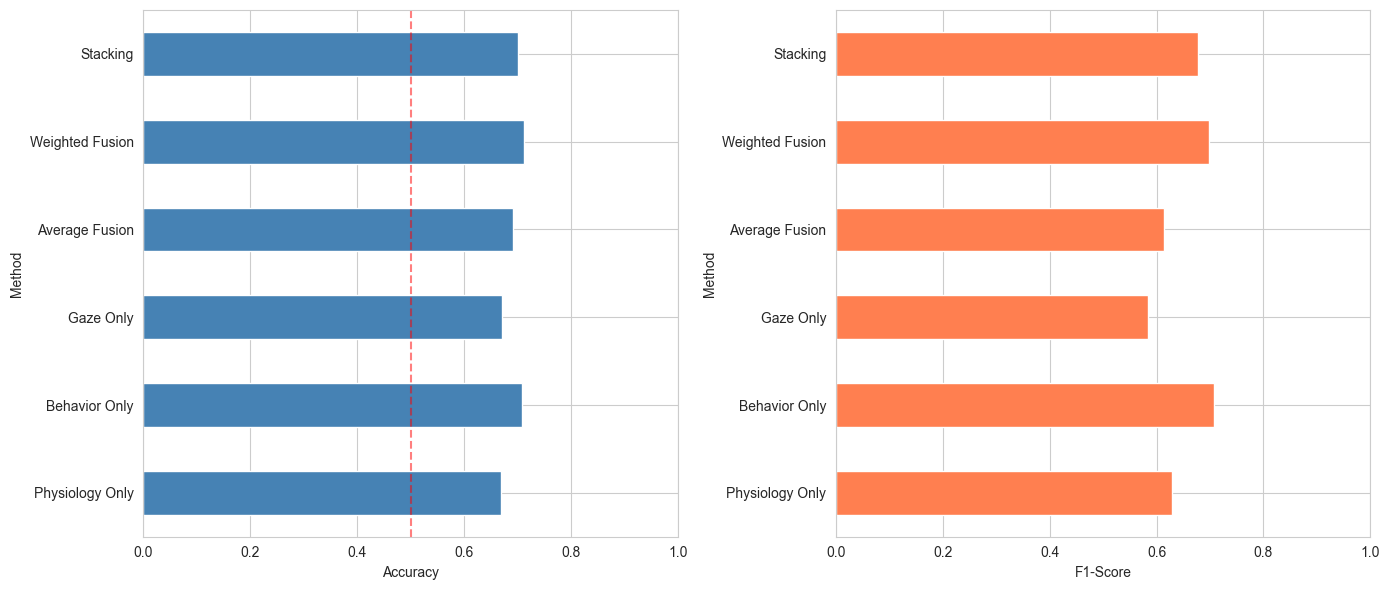

In [25]:
comparison_df = pd.DataFrame({
    'Method': ['Physiology Only', 'Behavior Only', 'Gaze Only',
               'Average Fusion', 'Weighted Fusion', 'Stacking'],
    'Accuracy': [acc_physio, acc_behavior, acc_gaze,
                 results_avg['accuracy'], results_weighted['accuracy'], results_stacking['accuracy']],
    'F1-Score': [f1_physio, f1_behavior, f1_gaze,
                 results_avg['f1_score'], results_weighted['f1_score'], results_stacking['f1_score']]
})

print("\n" + "="*70)
print("PERFORMANCE COMPARISON")
print("="*70)
print(comparison_df.to_string(index=False))

fig, ax = plt.subplots(1, 2, figsize=(14, 6))
comparison_df.plot(x='Method', y='Accuracy', kind='barh', ax=ax[0], legend=False, color='steelblue')
ax[0].set_xlabel('Accuracy')
ax[0].set_xlim([0, 1])
ax[0].axvline(0.5, color='red', linestyle='--', alpha=0.5)
comparison_df.plot(x='Method', y='F1-Score', kind='barh', ax=ax[1], legend=False, color='coral')
ax[1].set_xlabel('F1-Score')
ax[1].set_xlim([0, 1])
plt.tight_layout()
plt.show()

## 8. Visualize Modality Weights (Influence on Predictions)


MODALITY WEIGHTS (Influence on Prediction)
  Modality  Average  Weighted  Stacking
Physiology 0.333333  0.212235  0.324552
  Behavior 0.333333  0.345120  0.303150
      Gaze 0.333333  0.442645  0.372297


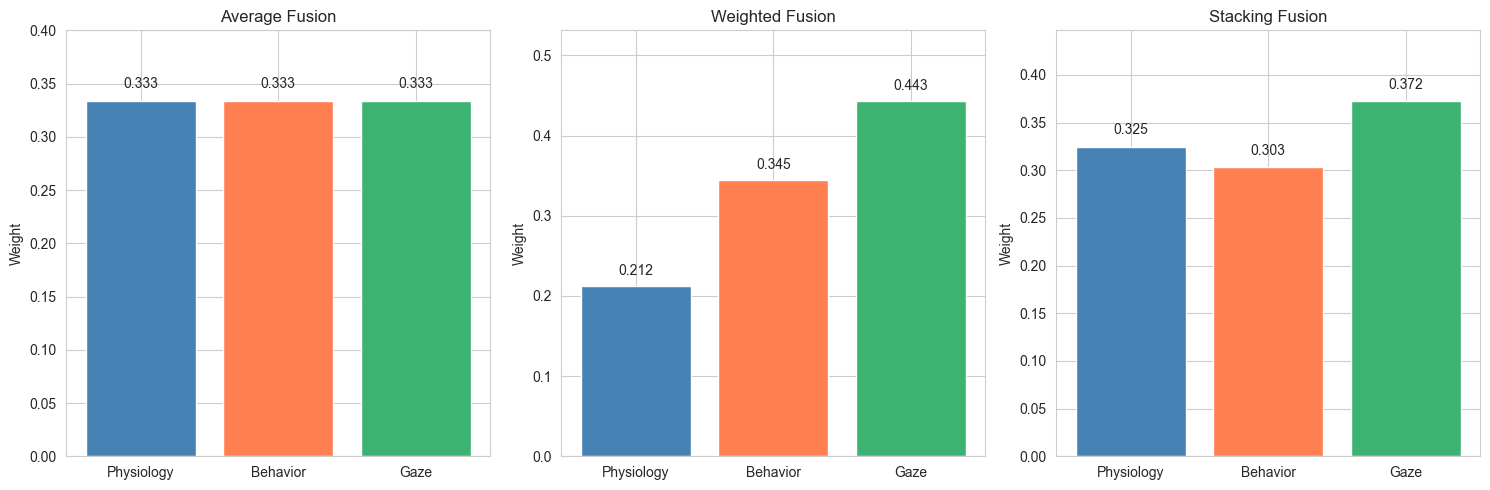

In [26]:
weights_df = pd.DataFrame({
    'Modality': modality_names,
    'Average': results_avg['weights'],
    'Weighted': results_weighted['weights'],
    'Stacking': results_stacking['weights']
})

print("\n" + "="*50)
print("MODALITY WEIGHTS (Influence on Prediction)")
print("="*50)
print(weights_df.to_string(index=False))

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
colors = ['steelblue', 'coral', 'mediumseagreen']

for idx, method in enumerate(['Average', 'Weighted', 'Stacking']):
    ax = axes[idx]
    weights = weights_df[method].values
    bars = ax.bar(modality_names, weights, color=colors)
    ax.set_ylabel('Weight')
    ax.set_title(f'{method} Fusion')
    ax.set_ylim([0, max(weights) * 1.2])
    for i, v in enumerate(weights):
        ax.text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

## 9. Summary

In [28]:
print("\n" + "="*70)
print("SUMMARY")
print("="*70)

print("\n1. INDIVIDUAL MODALITIES:")
print(f"   Physiology:  Acc={acc_physio:.3f}, F1={f1_physio:.3f}")
print(f"   Behavior:    Acc={acc_behavior:.3f}, F1={f1_behavior:.3f}")
print(f"   Gaze:        Acc={acc_gaze:.3f}, F1={f1_gaze:.3f}")

print("\n2. LATE FUSION METHODS:")
print(f"   Average:     Acc={results_avg['accuracy']:.3f}, F1={results_avg['f1_score']:.3f}")
print(f"   Weighted:    Acc={results_weighted['accuracy']:.3f}, F1={results_weighted['f1_score']:.3f}")
print(f"   Stacking:    Acc={results_stacking['accuracy']:.3f}, F1={results_stacking['f1_score']:.3f}")

print("\n3. MODALITY CONTRIBUTIONS (Weighted Fusion):")
for name, w in zip(modality_names, results_weighted['weights']):
    print(f"   {name:12s}: {w*100:5.1f}%")

best = comparison_df.loc[comparison_df['Accuracy'].idxmax()]
print(f"\n4. BEST METHOD: {best['Method']} (Acc={best['Accuracy']:.3f})")
print("\n" + "="*70)


SUMMARY

1. INDIVIDUAL MODALITIES:
   Physiology:  Acc=0.669, F1=0.628
   Behavior:    Acc=0.709, F1=0.708
   Gaze:        Acc=0.672, F1=0.584

2. LATE FUSION METHODS:
   Average:     Acc=0.692, F1=0.615
   Weighted:    Acc=0.712, F1=0.697
   Stacking:    Acc=0.700, F1=0.678

3. MODALITY CONTRIBUTIONS (Weighted Fusion):
   Physiology  :  21.2%
   Behavior    :  34.5%
   Gaze        :  44.3%

4. BEST METHOD: Weighted Fusion (Acc=0.712)

